In [1]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse


In [2]:
# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#Data Augmentation
Data augmentation performs random modifications of the image as a preprocessing step. It serves the following purposes:
1. It increases the amount of data for training.
2. By deleting features, it prevents the network from relying on a narrow set of features, which may not generalize.
3. By changing features while maintaining the same output, it helps the network become tolerant of changes that do not change the image lab. 

In short, data augmentation desensitivizes the network, so it extracts features that are invariant to changes that should not affect the prediction. 

We showcase a few random data augmentation provided by PyTorch.

In [3]:
! wget https://www.cesarsway.com/wp-content/uploads/2019/07/AdobeStock_197962036-1024x683.jpeg
! mv AdobeStock_197962036-1024x683.jpeg dog.jpg

--2021-10-04 17:06:12--  https://www.cesarsway.com/wp-content/uploads/2019/07/AdobeStock_197962036-1024x683.jpeg
正在解析主机 www.cesarsway.com (www.cesarsway.com)... 172.67.12.103, 104.22.31.81, 104.22.30.81
正在连接 www.cesarsway.com (www.cesarsway.com)|172.67.12.103|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 64141 (63K) [image/jpeg]
正在保存至: “AdobeStock_197962036-1024x683.jpeg”

AdobeStock_19796203 100%[===================>]  62.64K  --.-KB/s    用时 0.006s  

2021-10-04 17:06:14 (9.93 MB/s) - 已保存 “AdobeStock_197962036-1024x683.jpeg” [64141/64141])



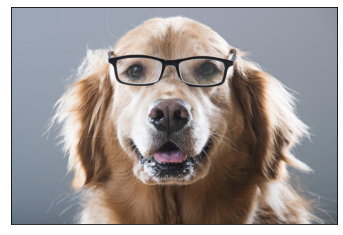

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.io import read_image

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

dog1 = read_image('dog.jpg')
show([dog1])
#dog1 = read_image(str(Path('assets') / 'dog1.jpg'))
#dog2 = read_image(str(Path('assets') / 'dog2.jpg'))
#show([dog1, dog2])1

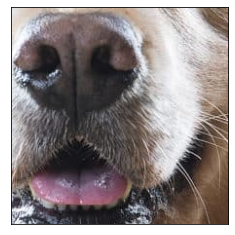

In [5]:
import torch.nn as nn
transforms = torch.nn.Sequential(
    T.RandomCrop(224), #randomly crop a 224x224 region from the image
    T.RandomHorizontalFlip(p=0.3), # with a given probability, perform horizontal flip
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dog1 = dog1.to(device)
# dog2 = dog2.to(device)

# transformed_dog1 = transforms(dog1)
transformed_dog1 = transforms(dog1)
show([transformed_dog1])

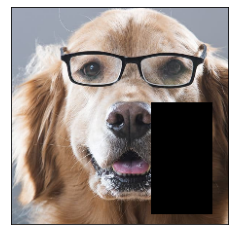

In [6]:
import torch.nn as nn
transforms = torch.nn.Sequential(
    T.Resize(256), # resize the short edge to 256.
    T.RandomCrop(224), #randomly crop a 224x224 region from the image
    T.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
    #T.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.1)
    #T.AutoAugment()
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dog1 = dog1.to(device)
# dog2 = dog2.to(device)

# transformed_dog1 = transforms(dog1)
transformed_dog1 = transforms(dog1)
show([transformed_dog1])

See more examples at: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py



---



In [7]:
# Training
def train(epoch, net, criterion, trainloader, scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
          print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

Test performance on the test set. Note the use of `torch.inference_mode()`

In [8]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [9]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [10]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [ ]:
import neptune
# main body
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 5e-4
}

# initialize Neptune
run = neptune.init('swagshaw/AI6103-Assignment',
                 api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0'
                           'cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2OWU'
                           'zZjNmZS0yYTdlLTQyNjctYWE2Mi0zODI1MTA0NzI1ZTIifQ==')
run["parameters"] = config

In [12]:

net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

for epoch in range(1, 200):
    train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    run['train/epoch/loss'].log(train_loss)
    run['train/epoch/accuracy'].log(train_acc)
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    


Epoch: 1


KeyboardInterrupt: 